**Name: Akash Badhautiya**

**Roll Number: 24AI60R43**

Task 1: Load the online news popularity dataset

In [11]:
import pandas as pd

# Load the dataset from the provided URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00477/Real%20estate%20valuation%20data%20set.xlsx"
data = pd.read_excel(url)

# Display basic information about the dataset
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB
None
   No  X1 transaction date  X2 house age  \
0   1          2012.916667          32.0   
1   2          2012.916667          19.5   
2   3          201

Task 2: Preprocess the dataset

In [12]:
from sklearn.preprocessing import StandardScaler

# Remove duplicates
data = data.drop_duplicates()

# Check for missing values and handle them
print(data.isnull().sum())  # Check for missing values

data = data.dropna()

# Features scaling (ignoring non-numerical columns, if any)
features = data.drop(['No'], axis=1)  # Drop 'No' (row number) if it's not useful for prediction
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Reassemble the scaled dataset
data_scaled = pd.DataFrame(scaled_features, columns=features.columns)
data_scaled['Price'] = data['Y house price of unit area']

# Show updated data
print(data_scaled.head())


No                                        0
X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64
   X1 transaction date  X2 house age  X3 distance to the nearest MRT station  \
0            -0.824722      1.255628                               -0.792495   
1            -0.824722      0.157086                               -0.616612   
2             1.542244     -0.387791                               -0.414015   
3             1.246373     -0.387791                               -0.414015   
4            -1.120593     -1.117223                               -0.549997   

   X4 number of convenience stores  X5 latitude  X6 longitude  \
0                         2.007407     1.125430      0.448762   
1                       

Task 3: Split the dataset

In [13]:
from sklearn.model_selection import train_test_split

# Define features and target
X = data_scaled.drop('Price', axis=1)
y = data_scaled['Price']

# Split into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Confirm sizes of the sets
print(f"Training set: {len(X_train)}, Validation set: {len(X_val)}, Test set: {len(X_test)}")


Training set: 289, Validation set: 62, Test set: 63


Task 4: Train Support Vector Regressors (SVR) using Polynomial and RBF kernels

In [14]:
from sklearn.svm import SVR

# Polynomial Kernel SVR
svr_poly = SVR(kernel='poly')
svr_poly.fit(X_train, y_train)

# RBF Kernel SVR
svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(X_train, y_train)


SVR()

Task 5: Perform cross-validation using GridSearchCV to choose the best parameters

In [15]:
from sklearn.model_selection import GridSearchCV

# Polynomial Kernel SVR: Grid Search for best degree
param_grid_poly = {'degree': [2, 3, 4, 5, 6]}
grid_poly = GridSearchCV(SVR(kernel='poly'), param_grid_poly, cv=5, scoring='neg_mean_squared_error')
grid_poly.fit(X_train, y_train)
best_degree = grid_poly.best_params_['degree']
print(f"Best Polynomial Degree: {best_degree}")

# RBF Kernel SVR: Grid Search for best gamma
param_grid_rbf = {'gamma': [0.01, 0.1, 1, 10, 100]}
grid_rbf = GridSearchCV(SVR(kernel='rbf'), param_grid_rbf, cv=5, scoring='neg_mean_squared_error')
grid_rbf.fit(X_train, y_train)
best_gamma = grid_rbf.best_params_['gamma']
print(f"Best Gamma for RBF: {best_gamma}")


Best Polynomial Degree: 3
Best Gamma for RBF: 0.1


Task 6: Plot MSE vs. Polynomial degree

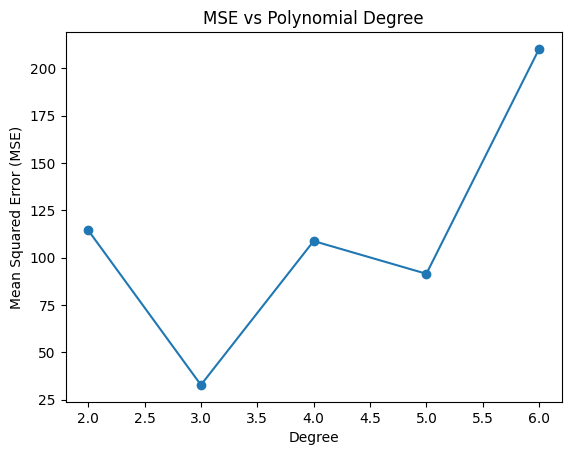

In [16]:
import matplotlib.pyplot as plt

# Extract MSE for Polynomial Kernel and plot
degrees = param_grid_poly['degree']
mse_poly = -grid_poly.cv_results_['mean_test_score']

plt.figure()
plt.plot(degrees, mse_poly, marker='o')
plt.title('MSE vs Polynomial Degree')
plt.xlabel('Degree')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()


Task 7: Plot MSE vs. Gamma value for RBF kernel

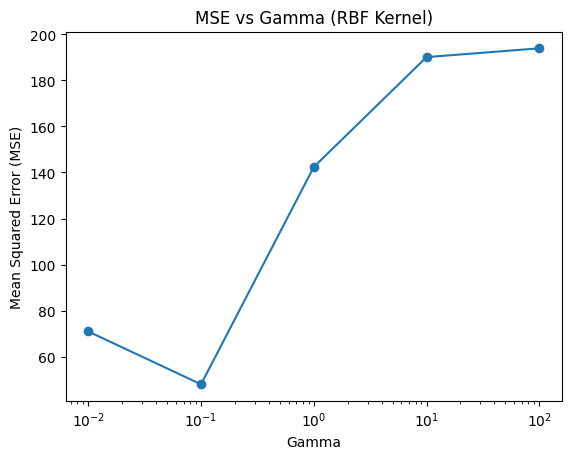

In [17]:
# Extract MSE for RBF Kernel and plot
gammas = param_grid_rbf['gamma']
mse_rbf = -grid_rbf.cv_results_['mean_test_score']

plt.figure()
plt.plot(gammas, mse_rbf, marker='o')
plt.title('MSE vs Gamma (RBF Kernel)')
plt.xlabel('Gamma')
plt.ylabel('Mean Squared Error (MSE)')
plt.xscale('log')  # Log scale for better visualization of gamma values
plt.show()


Task 8: Obtain predictions and plot scatter plot

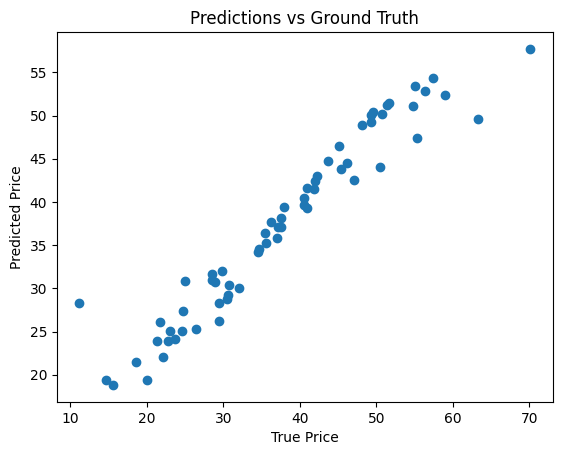

In [18]:
import numpy as np

# Choose the best model between polynomial and RBF based on validation MSE
best_poly_model = grid_poly.best_estimator_
best_rbf_model = grid_rbf.best_estimator_

# Use the validation set for comparison
val_mse_poly = np.mean((best_poly_model.predict(X_val) - y_val) ** 2)
val_mse_rbf = np.mean((best_rbf_model.predict(X_val) - y_val) ** 2)

best_model = best_poly_model if val_mse_poly < val_mse_rbf else best_rbf_model

# Predictions and scatter plot
predictions = best_model.predict(X_test)

plt.figure()
plt.scatter(y_test, predictions)
plt.title('Predictions vs Ground Truth')
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.show()


R-squared and MSE:

In [19]:
from sklearn.metrics import mean_squared_error, r2_score

# Get predictions from both models on the test set
y_pred_poly = best_poly_model.predict(X_test)
y_pred_rbf = best_rbf_model.predict(X_test)

# Calculate MSE and R-squared for the Polynomial kernel model
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

# Calculate MSE and R-squared for the RBF kernel model
mse_rbf = mean_squared_error(y_test, y_pred_rbf)
r2_rbf = r2_score(y_test, y_pred_rbf)

# Print results
print(f"Polynomial Kernel SVR - MSE: {mse_poly:.4f}, R-squared: {r2_poly:.4f}")
print(f"RBF Kernel SVR - MSE: {mse_rbf:.4f}, R-squared: {r2_rbf:.4f}")


Polynomial Kernel SVR - MSE: 33.2151, R-squared: 0.8008
RBF Kernel SVR - MSE: 16.2546, R-squared: 0.9025


HyperParameter Tuning

In [20]:
param_grid_rbf_tuned = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1]
}

grid_rbf_tuned = GridSearchCV(SVR(kernel='rbf'), param_grid_rbf_tuned, cv=5, scoring='neg_mean_squared_error')
grid_rbf_tuned.fit(X_train, y_train)

# Best hyperparameters for RBF kernel
print(f"Best parameters for RBF Kernel SVR: {grid_rbf_tuned.best_params_}")

# Evaluate performance of the tuned model
best_rbf_tuned_model = grid_rbf_tuned.best_estimator_
y_pred_rbf_tuned = best_rbf_tuned_model.predict(X_test)

mse_rbf_tuned = mean_squared_error(y_test, y_pred_rbf_tuned)
r2_rbf_tuned = r2_score(y_test, y_pred_rbf_tuned)

print(f"Tuned RBF Kernel SVR - MSE: {mse_rbf_tuned:.4f}, R-squared: {r2_rbf_tuned:.4f}")


Best parameters for RBF Kernel SVR: {'C': 100, 'epsilon': 0.1, 'gamma': 0.01}
Tuned RBF Kernel SVR - MSE: 0.0688, R-squared: 0.9996
